In [1]:
!pip install deepxde


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%env DDE_BACKEND=tensorflow
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

def func(x):
    return x * np.sin(5 * x)

def train(model, iterations, display_every, loss_test, loss_train):
    for i in range(iterations):
        model.train_state.set_data_train(
            *model.data.train_next_batch(model.batch_size)
        )
        model.train_step(
            model.train_state.X_train,
            model.train_state.y_train,
            model.train_state.train_aux_vars,
        )

        X_test, y_test = model.data.test()
        y_pred = model.predict(X_test)
        l2_loss_test = np.linalg.norm(y_pred - y_test)*np.linalg.norm(y_pred - y_test)
        # l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)
        loss_test.append(l2_loss_test)

        X_train, y_train = model.data.train_x, model.data.train_y
        y_pred = model.predict(X_train)
        l2_loss_train = np.linalg.norm(y_pred - y_train)*np.linalg.norm(y_pred - y_train)
        # l2l = np.linalg.norm(y_pred - y_train)/np.linalg.norm(y_train)
        loss_train.append(l2_loss_train)

        model.train_state.epoch += 1
        model.train_state.step += 1
        if model.train_state.step % display_every == 0 or i + 1 == iterations:
            print(str(model.train_state.step) + " " + str(loss_test[-1]))

def test(seed):
    dde.config.set_default_float("float32")
    dde.config.set_random_seed(seed)
    print("Training Float32:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_test_32 = []
    loss_train_32 = []
    train(model, 10000, 1000, loss_test_32, loss_train_32) # 10000

    dde.config.set_default_float("float16")
    dde.config.set_random_seed(seed)
    print("Training Float16:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_test_16 = []
    loss_train_16 = []
    train(model, 10000, 1000, loss_test_16, loss_train_16) # 10000

    return loss_test_32, loss_test_16, loss_train_32, loss_train_16

env: DDE_BACKEND=tensorflow


2024-01-04 19:23:47.791818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float32
Training Float32:
Compiling model...
'compile' took 0.010250 s

1000 3.652507
2000 0.14346156
3000 0.09265575
4000 0.058981482
5000 0.021714209
6000 0.007991245
7000 0.006644982
8000 0.006146135
9000 0.0054103755
10000 0.005404102
Set the default float type to float16
Training Float16:
Compiling model...
'compile' took 0.003048 s

1000 0.2372
2000 0.1863
3000 0.1628
4000 0.1489
5000 0.1304
6000 0.11786
7000 0.1064
8000 0.1009
9000 0.096
10000 0.09357


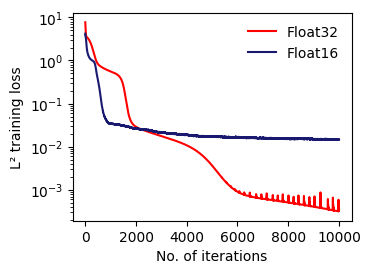

In [6]:
seed = 3
loss_test_32, loss_test_16, loss_train_32, loss_train_16 = test(seed)
x = [i for i in range(len(loss_test_32))]
#plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
plt.ylabel('L² training loss')
plt.yscale('log')
# plt.plot(x, loss_test_32, label = "Testing float32", color = 'orange', linestyle='dashed')
# plt.plot(x, loss_test_16, label = "Testing float16", color = 'cornflowerblue', linestyle='dashed')
# plt.plot(x, loss_train_32, label = "Training float32", color = 'red')
# plt.plot(x, loss_train_16, label = "Training float16", color = 'midnightblue')
plt.plot(x, loss_train_32, label = "Float32", color = 'red')
plt.plot(x, loss_train_16, label = "Float16", color = 'midnightblue')
plt.legend(loc='upper right', frameon = False)
plt.savefig("phases-" + str(seed) + ".pdf", bbox_inches='tight')
plt.show()

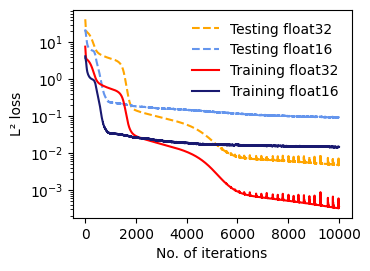

In [5]:
x = [i for i in range(len(loss_test_32))]
#plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
plt.ylabel('L² loss')
plt.yscale('log')
plt.plot(x, loss_test_32, label = "Testing float32", color = 'orange', linestyle='dashed')
plt.plot(x, loss_test_16, label = "Testing float16", color = 'cornflowerblue', linestyle='dashed')
plt.plot(x, loss_train_32, label = "Training float32", color = 'red')
plt.plot(x, loss_train_16, label = "Training float16", color = 'midnightblue')
# plt.plot(x, loss_train_32, label = "Float32", color = 'red')
# plt.plot(x, loss_train_16, label = "Float16", color = 'midnightblue')
plt.legend(loc='upper right', frameon = False)
plt.savefig("phases-" + str(seed) + "-full.pdf", bbox_inches='tight')
plt.show()